# Key Insights

In [9]:
import pandas as pd
import yaml

results = pd.read_csv(open("../results/benchmark_results.csv"))
meta = yaml.safe_load(open("../results/metadata.yaml"))

results["bench-size"] = results["Benchmark"] + "-" + results["Size"]
results["solver-version"] = results["Solver"] + "-" + results["Solver Version"]

## How good is each solver and for what cases?

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from humanize import naturaldelta
from matplotlib.patches import Patch

In [309]:
max_num_solvers = 5  # TODO

# Color map
color_map = {
    "cbc": "#F9CD5A",  # yellow
    "glpk": "#7C3AED",  # purple
    "gurobi": "#F66C49",  # red
    "highs": "#43BF94",  # green
    "scip": "#3B82F6",  # blue
}  # TODO change these colors on the website too!


def plot_runtime_slowdowns(df, figsize=(12, 6)):
    """Plots relative runtimes (slowdown factors) in a bar chart.

    Expects df to have columns: Benchmark, Solver, Runtime (s), Status, Timeout
    """
    if "bench-size" in df.columns:
        df["Benchmark"] = df["bench-size"]
    # Fill NaN runtimes and non-ok statuses with TO value
    df.loc[df["Runtime (s)"].isna(), "Runtime (s)"] = df["Timeout"]
    df.loc[df.query('Status != "ok"').index, "Runtime (s)"] = df["Timeout"]

    # Find the fastest solver for each benchmark
    df_ok = df.query('Status == "ok"')
    fastest_runtimes = df_ok.loc[df_ok.groupby("Benchmark")["Runtime (s)"].idxmin()]

    # Sort benchmarks by fastest runtime
    sorted_benchmarks = fastest_runtimes.sort_values("Runtime (s)").reset_index(
        drop=True
    )

    # Normalize runtimes to find each solver's slowdown factor
    df = df.merge(
        fastest_runtimes[["Benchmark", "Runtime (s)"]],
        on="Benchmark",
        suffixes=("", "_fastest"),
    )
    df["Slowdown"] = df["Runtime (s)"] / df["Runtime (s)_fastest"]
    max_slowdown = max(df.query('Status == "ok"')["Slowdown"])
    df.loc[df.query('Status != "ok"').index, "Slowdown"] = 1.1 * max_slowdown

    width = 1 / (max_num_solvers + 1)  # the width of the bars

    fig, ax = plt.subplots(figsize=figsize, layout="constrained")

    # Add a dotted line at y=1
    ax.axhline(1, color="grey", linestyle="--")

    # Plot each benchmark
    for i, benchmark in enumerate(sorted_benchmarks["Benchmark"]):
        benchmark_data = df[df["Benchmark"] == benchmark].sort_values(
            "Slowdown", ascending=True
        )
        num_solvers = len(benchmark_data)
        # Compute x-axis offsets
        xs = i + (np.arange(num_solvers) * width) - 0.5 + width
        # Pick colors based on solvers
        # colors = [color_map[s] for s in benchmark_data["Solver"]]
        colors = [
            color_map[r["Solver"]]
            if r["Status"] == "ok"
            else (color_map[r["Solver"]], 0.2)
            for _, r in benchmark_data.iterrows()
        ]
        # Push down non-ok bars to not make them distracting
        # benchmark_data.loc[benchmark_data.query('Status != "ok"').index, "Slowdown"] = 1
        ax.bar(xs, benchmark_data["Slowdown"], width, color=colors)
        # Add text labels on top of bars
        for i, x in enumerate(xs):
            if benchmark_data.iloc[i]["Status"] == "ok":
                y = benchmark_data.iloc[i]["Slowdown"] + 0.5
                label = f"{benchmark_data.iloc[i]['Slowdown']:.1f}x"
                kwargs = {}
            else:
                # y = 1.1
                y = benchmark_data.iloc[i]["Slowdown"] + 0.5
                label = benchmark_data.iloc[i]["Status"]
                kwargs = {"color": "red", "weight": "bold"}
            ax.text(
                x,
                y,
                label,
                ha="center",
                **kwargs,
            )

    # Set x-ticks and labels
    xlabels = [
        f"{r['Benchmark']}\nFastest solver: {naturaldelta(r['Runtime (s)'])}"
        for _, r in sorted_benchmarks.iterrows()
    ]
    ax.set_xticks(np.arange(len(sorted_benchmarks)), xlabels)

    # Add labels and title
    ax.set_ylabel("Relative Runtime (normalized)")
    ax.set_title("Solver Runtime Comparison")
    ax.legend(
        handles=[Patch(color=c, label=s) for s, c in color_map.items()],
        title="Solver",
        loc="upper right",
    )


# TODO for overall plot -- num solved inside bar?
# TODO make non-ok bars more transparent?

In [303]:
def plot_runtime_slowdowns_of(results, to_plot, figsize=(12, 6)):
    to_plot_results = results[results["bench-size"].isin(to_plot)]

    # Remove old solver versions
    to_plot_results = to_plot_results.sort_values(
        ["bench-size", "Solver", "Solver Release Year"]
    ).drop_duplicates(["bench-size", "Solver"], keep="last")

    plot_runtime_slowdowns(to_plot_results, figsize=figsize)

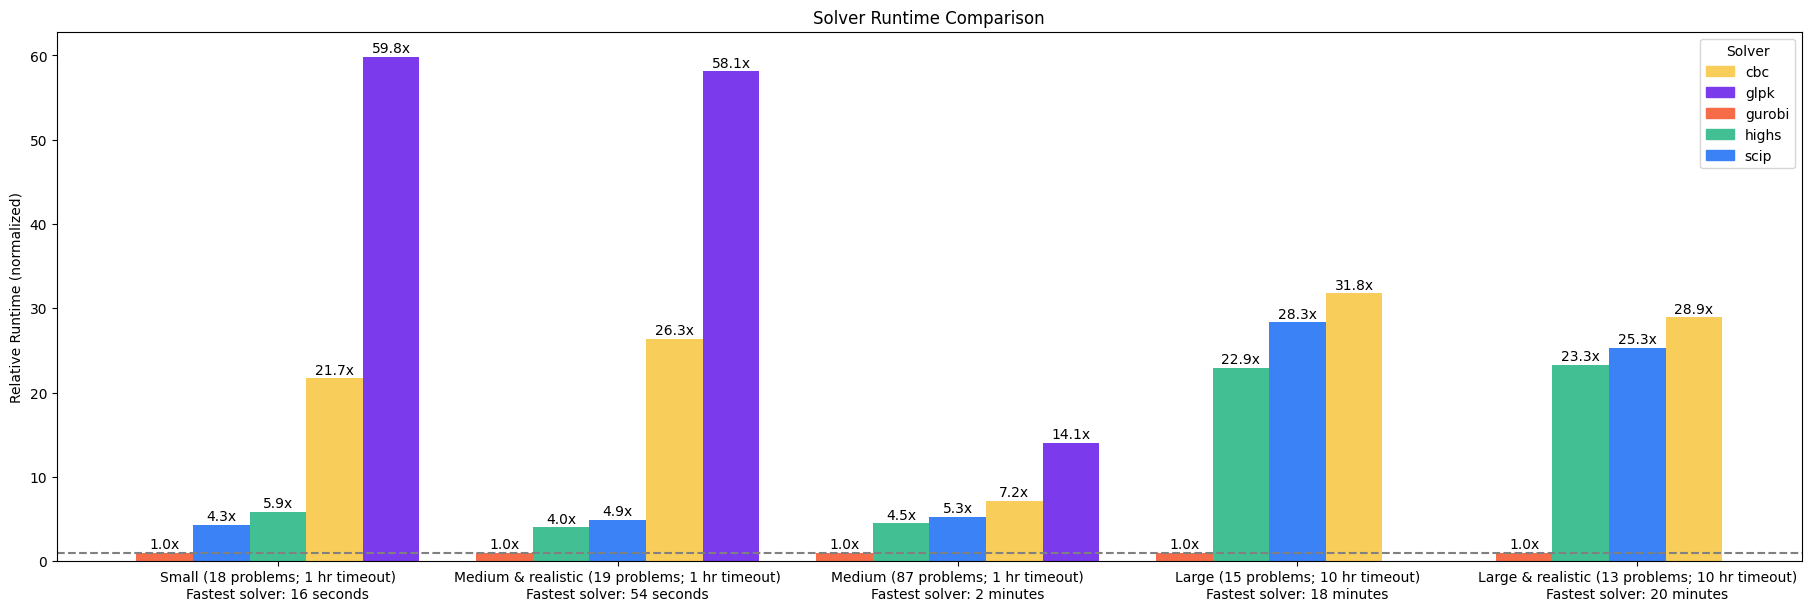

In [311]:
from io import StringIO

# SGM results
data = """Benchmark,Solver,Runtime (s),Status,Timeout
Small (18 problems; 1 hr timeout),gurobi,16.1,ok
Small (18 problems; 1 hr timeout),highs,94.61,ok
Small (18 problems; 1 hr timeout),scip,68.89,ok
Small (18 problems; 1 hr timeout),cbc,349.43,ok
Small (18 problems; 1 hr timeout),glpk,963.3,ok
Medium (87 problems; 1 hr timeout),gurobi,125.25,ok
Medium (87 problems; 1 hr timeout),highs,560.11,ok
Medium (87 problems; 1 hr timeout),scip,659.39,ok
Medium (87 problems; 1 hr timeout),cbc,899.76,ok
Medium (87 problems; 1 hr timeout),glpk,1761.3,ok
Medium & realistic (19 problems; 1 hr timeout),gurobi,54.86,ok
Medium & realistic (19 problems; 1 hr timeout),highs,220.96,ok
Medium & realistic (19 problems; 1 hr timeout),scip,267.89,ok
Medium & realistic (19 problems; 1 hr timeout),cbc,1445.51,ok
Medium & realistic (19 problems; 1 hr timeout),glpk,3189.2,ok
Large (15 problems; 10 hr timeout),gurobi,1124.64,ok
Large (15 problems; 10 hr timeout),highs,25793.13,ok
Large (15 problems; 10 hr timeout),scip,31847.48,ok
Large (15 problems; 10 hr timeout),cbc,35747.02,ok
Large & realistic (13 problems; 10 hr timeout),gurobi,1235.35,ok
Large & realistic (13 problems; 10 hr timeout),highs,28762.75,ok
Large & realistic (13 problems; 10 hr timeout),scip,31252.59,ok
Large & realistic (13 problems; 10 hr timeout),cbc,35708.26,ok
"""
df = pd.read_csv(StringIO(data))

# TODO add num solved as fraction

plot_runtime_slowdowns(df, figsize=(18, 6))

### Canonical / representative / featured problems

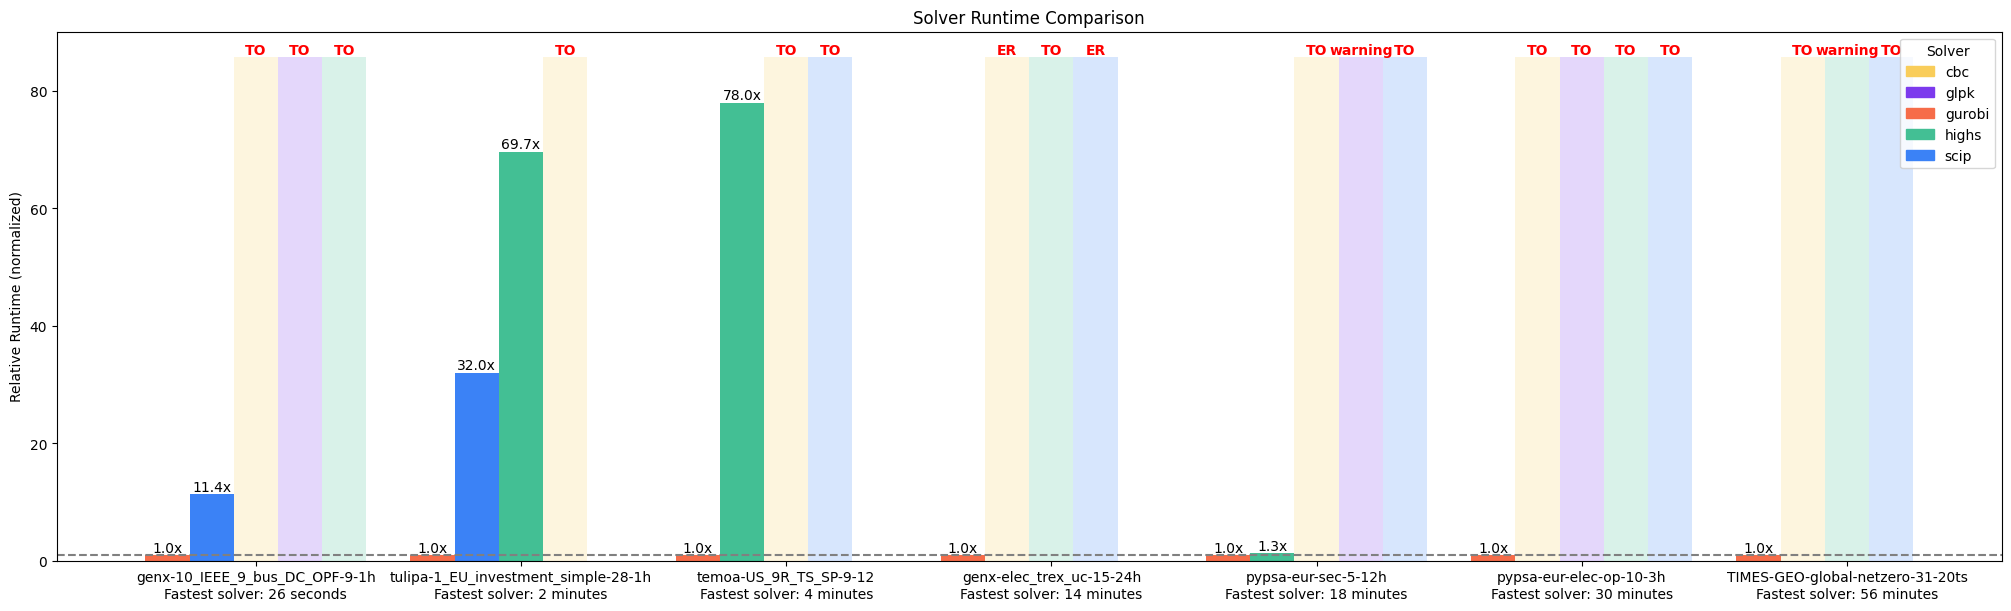

In [310]:
to_plot = {
    "pypsa-eur-elec-op-10-3h",
    "pypsa-eur-sec-5-12h",
    "genx-10_IEEE_9_bus_DC_OPF-9-1h",
    "genx-elec_trex_uc-15-24h",
    "tulipa-1_EU_investment_simple-28-1h",
    "temoa-US_9R_TS_SP-9-12",
    "TIMES-GEO-global-netzero-31-20ts",
}
to_plot_results = results[results["bench-size"].isin(to_plot)]

# Remove old solver versions
to_plot_results = to_plot_results.sort_values(
    ["bench-size", "Solver", "Solver Release Year"]
).drop_duplicates(["bench-size", "Solver"], keep="last")

plot_runtime_slowdowns(to_plot_results, figsize=(20, 6))

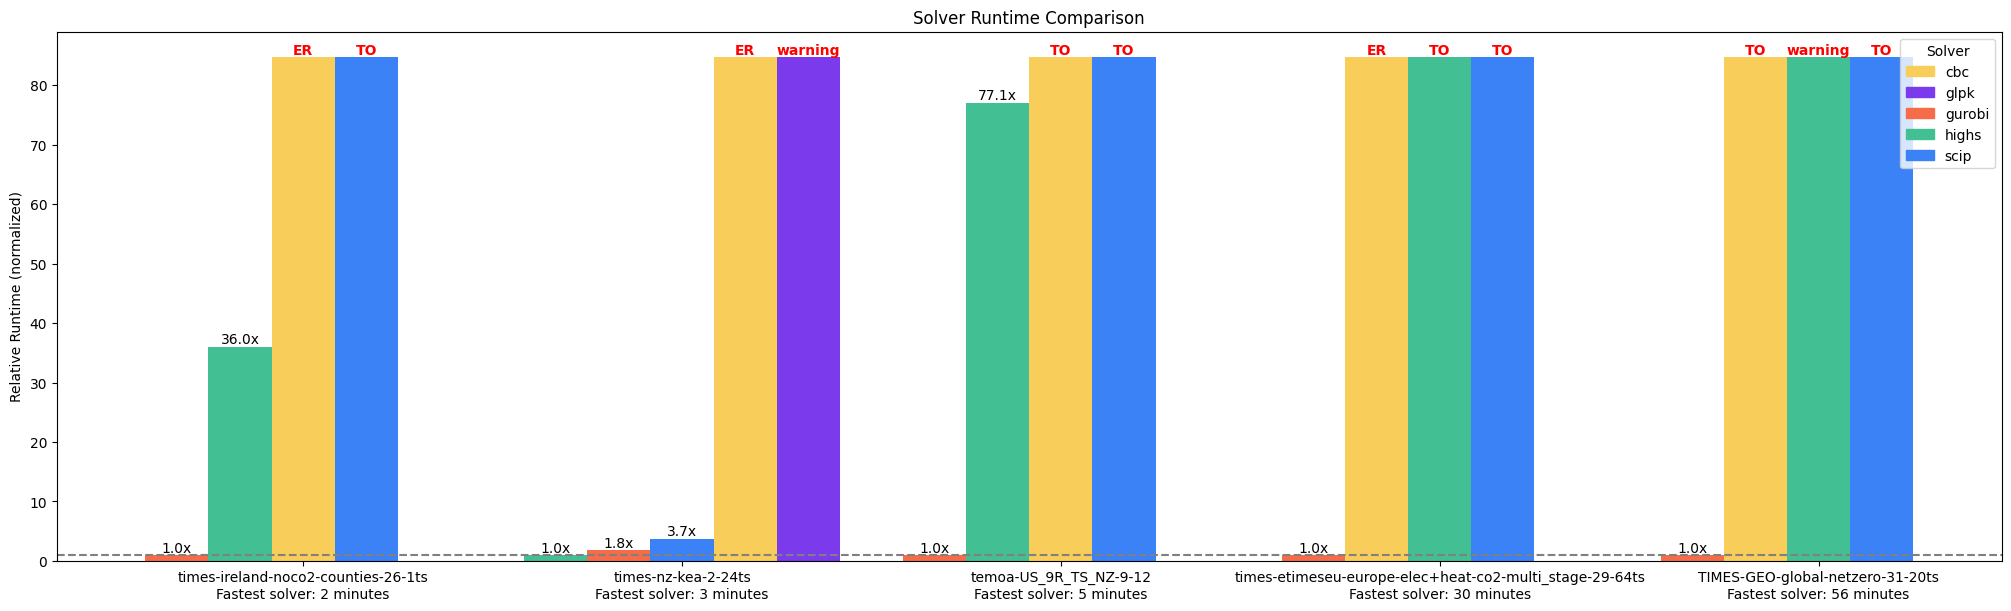

In [308]:
times_problems = [
    "times-etimeseu-france-elec+heat-co2-multi_stage",
    "TIMES-GEO-global-netzero",
    "times-etimeseu-france-elec+heat-multi_stage",
    "times-etimeseu-france-elec+heat-co2-single_stage",
    "times-ireland-noco2",
    "times-etimeseu-europe-elec+heat-multi_stage",
    "times-etimeseu-europe-elec+heat-co2-multi_stage",
    "times-etimeseu-europe-elec+heat-co2-single_stage",
    "TIMES-GEO-global-base",
    "times-nz-tui",
    "times-etimeseu-france-elec+heat-single_stage",
    "times-ireland-noco2-counties",
    "times-etimeseu-europe-elec+heat-single_stage",
    "times-nz-kea",
]
times_to_plot = {
    "TIMES-GEO-global-netzero",
    "times-etimeseu-europe-elec+heat-co2-multi_stage",
    "times-nz-kea",
    "times-ireland-noco2-counties",
    "temoa-US_9R_TS_NZ",
}
times_results = results[results["Benchmark"].isin(times_to_plot)]

# Fix size names
times_results.loc[
    times_results.query('`bench-size` == "times-ireland-noco2-counties-26-1h"').index,
    "bench-size",
] = "times-ireland-noco2-counties-26-1ts"
times_results.loc[
    times_results.query('`bench-size` == "times-nz-kea-2-24h"').index, "bench-size"
] = "times-nz-kea-2-24ts"

# Remove old solver versions
times_results = times_results.sort_values(
    ["bench-size", "Solver", "Solver Release Year"]
).drop_duplicates(["bench-size", "Solver"], keep="last")

plot_runtime_slowdowns(times_results, figsize=(20, 6))

## What's feasible for open source solvers?

In [53]:
import humanize

# Make a table of metadata
meta_data = []
for n, b in meta["benchmarks"].items():
    for s in b["Sizes"]:
        bench_size = n + "-" + s["Name"]
        meta_data.append(
            (
                bench_size,
                b["Problem class"],
                b["Modelling framework"],
                s["Num. variables"],
                s["Num. constraints"],
                s["Spatial resolution"],
                s["Temporal resolution"],
            )
        )
metadata_df = pd.DataFrame(
    meta_data,
    columns=[
        "bench-size",
        "Problem Class",
        "Modelling Framework",
        "Num. Variables",
        "Num. Constraints",
        "Spatial Resolution",
        "Temporal Resolution",
    ],
)

# Merge to get a table with bench-size, fastest os solver, runtime, num vars, num constraints, temp/spatial resolutions
results_n_meta = results.join(metadata_df.set_index("bench-size"), on="bench-size")
results_n_meta["Runtime"] = results_n_meta["Runtime (s)"].apply(humanize.naturaldelta)

# First get the fastest OS solver for each bench-size
os_feasible_results = (
    results_n_meta.query("Solver != 'gurobi' and Status == 'ok'")
    .sort_values("Runtime (s)")
    .drop_duplicates(["bench-size"])
)

# The fastest Gurobi solver for each bench-size
gurobi_results = (
    results_n_meta.query("Solver == 'gurobi' and Status == 'ok'")
    .sort_values("Runtime (s)")
    .drop_duplicates(["bench-size"])
)

cols_of_interest = [
    "Benchmark",
    "Size",
    "Num. Variables",
    "Num. Constraints",
    "Spatial Resolution",
    "Temporal Resolution",
    "Solver",
    "Solver Version",
    "Runtime",
]

In [54]:
# Add Gurobi results as a separate column for comparison
print(os_feasible_results.shape)
os_feasible_results = os_feasible_results.join(
    results.query('Solver == "gurobi" and `Solver Release Year` == 2024')[
        ["bench-size", "Runtime (s)"]
    ].set_index("bench-size"),
    on="bench-size",
    how="inner",
    rsuffix=" - Gurobi",
)
print(os_feasible_results.shape)
os_feasible_results["Runtime - Gurobi"] = os_feasible_results[
    "Runtime (s) - Gurobi"
].apply(humanize.naturaldelta)
cols_of_interest.append("Runtime - Gurobi")

(86, 26)
(86, 27)


In [56]:
# The largest LP problems solveable by open solvers + largest by Gurobi
largest_lp_results = (
    os_feasible_results.query('`Problem Class` == "LP"')
    .sort_values("Num. Variables", ascending=False)
    .head(4)
)
largest_lp_gurobi = (
    gurobi_results.query('`Problem Class` == "LP"')
    .sort_values("Num. Variables", ascending=False)
    .head(1)
)
largest_lp_results = pd.concat([largest_lp_gurobi, largest_lp_results])

largest_lp_results[cols_of_interest]

,Benchmark,Size,Num. Variables,Num. Constraints,Spatial Resolution,Temporal Resolution,Solver,Solver Version,Runtime,Runtime - Gurobi
464,genx-elec_trex_co2,15-168h,13777227,11832689,15,168,gurobi,12.0.0,4 hours,NaN
792,temoa-US_9R_TS_NZ,9-12,1801794,1594085,9 nodes,"12 time slices (4 seasons, 3 times of day)",highs,1.10.0,7 hours,5 minutes
499,temoa-US_9R_TS_SP,9-12,1801794,1594116,9 nodes,"12 time slices (4 seasons, 3 times of day)",highs,1.10.0,5 hours,4 minutes
1072,temoa-US_9R_TS,9-12,1801794,1594079,9 nodes,"12 time slices (4 seasons, 3 times of day)",highs,1.10.0,3 hours,3 minutes
1016,times-ireland-noco2-counties,26-1h,1235884,873805,26 (Transport) / 1 (all other sectors),1,highs,1.10.0,an hour,2 minutes


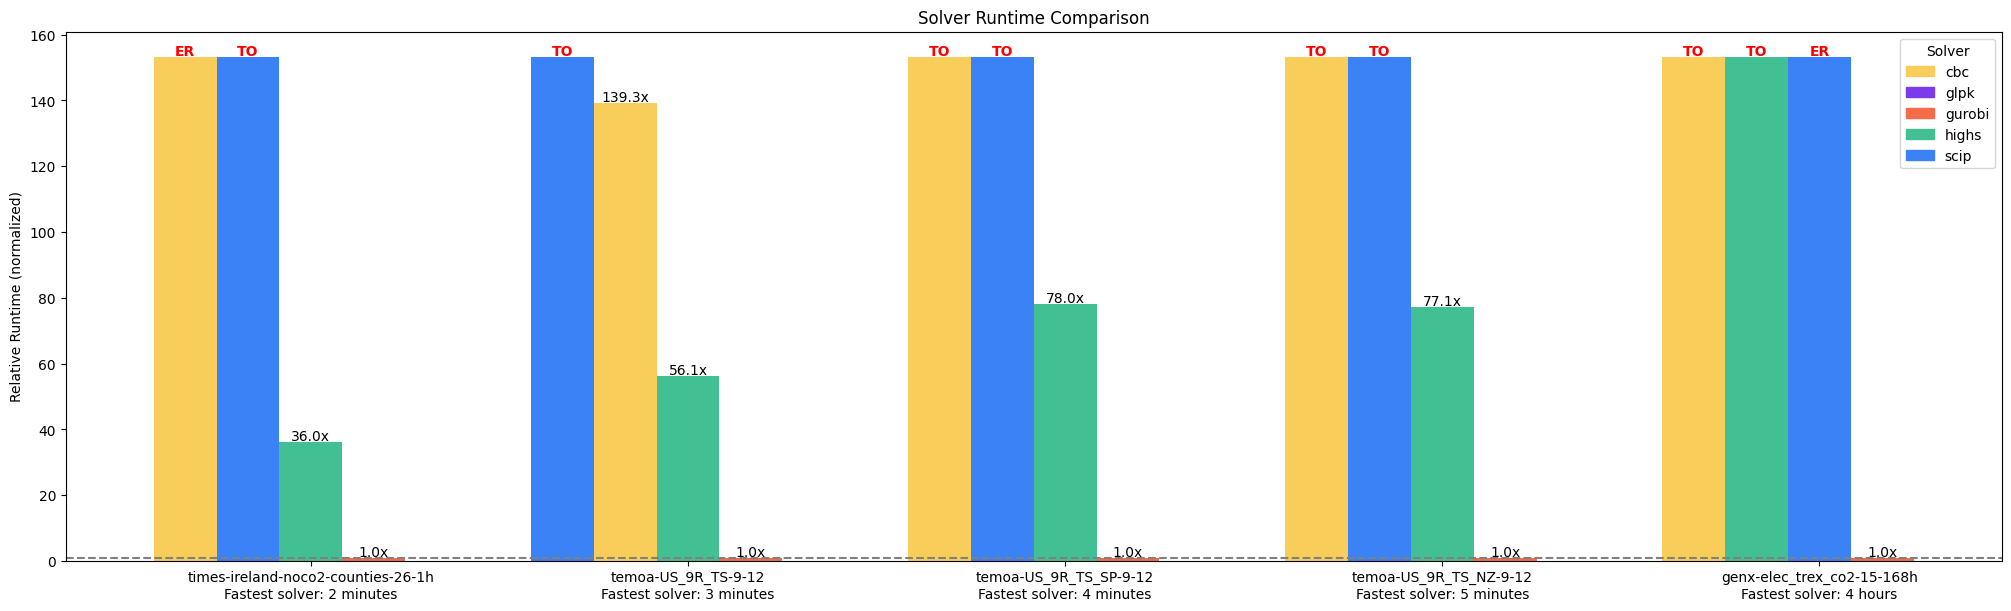

In [60]:
plot_runtime_slowdowns_of(results, set(largest_lp_results["bench-size"]))

In [57]:
# The largest MILP problems solveable by open solvers + largest by Gurobi
largest_milp_results = (
    os_feasible_results.query('`Problem Class` == "MILP"')
    .sort_values("Num. Variables", ascending=False)
    .head(4)
)
largest_milp_gurobi = (
    gurobi_results.query('`Problem Class` == "MILP"')
    .sort_values("Num. Variables", ascending=False)
    .head(1)
)
largest_milp_results = pd.concat([largest_milp_gurobi, largest_milp_results])

largest_milp_results[cols_of_interest]

,Benchmark,Size,Num. Variables,Num. Constraints,Spatial Resolution,Temporal Resolution,Solver,Solver Version,Runtime,Runtime - Gurobi
468,genx-elec_trex_uc,15-24h,2551346,3123898,15,24h,gurobi,12.0.0,14 minutes,NaN
1013,tulipa-1_EU_investment_simple,28-1h,1619451,2429440,28,1,scip,9.2.2,an hour,2 minutes
694,genx-10_IEEE_9_bus_DC_OPF,9-1h,639483,1235166,9,1,scip,9.2.2,5 minutes,26 seconds
1372,tulipa-1_EU_investment_simple,28-4.3h,372935,559104,28,4.3,scip,9.2.2,2 minutes,31 seconds
1264,pypsa-eur-elec-op-ucconv,2-3h,186880,385478,2,3,scip,9.2.2,12 minutes,28 seconds


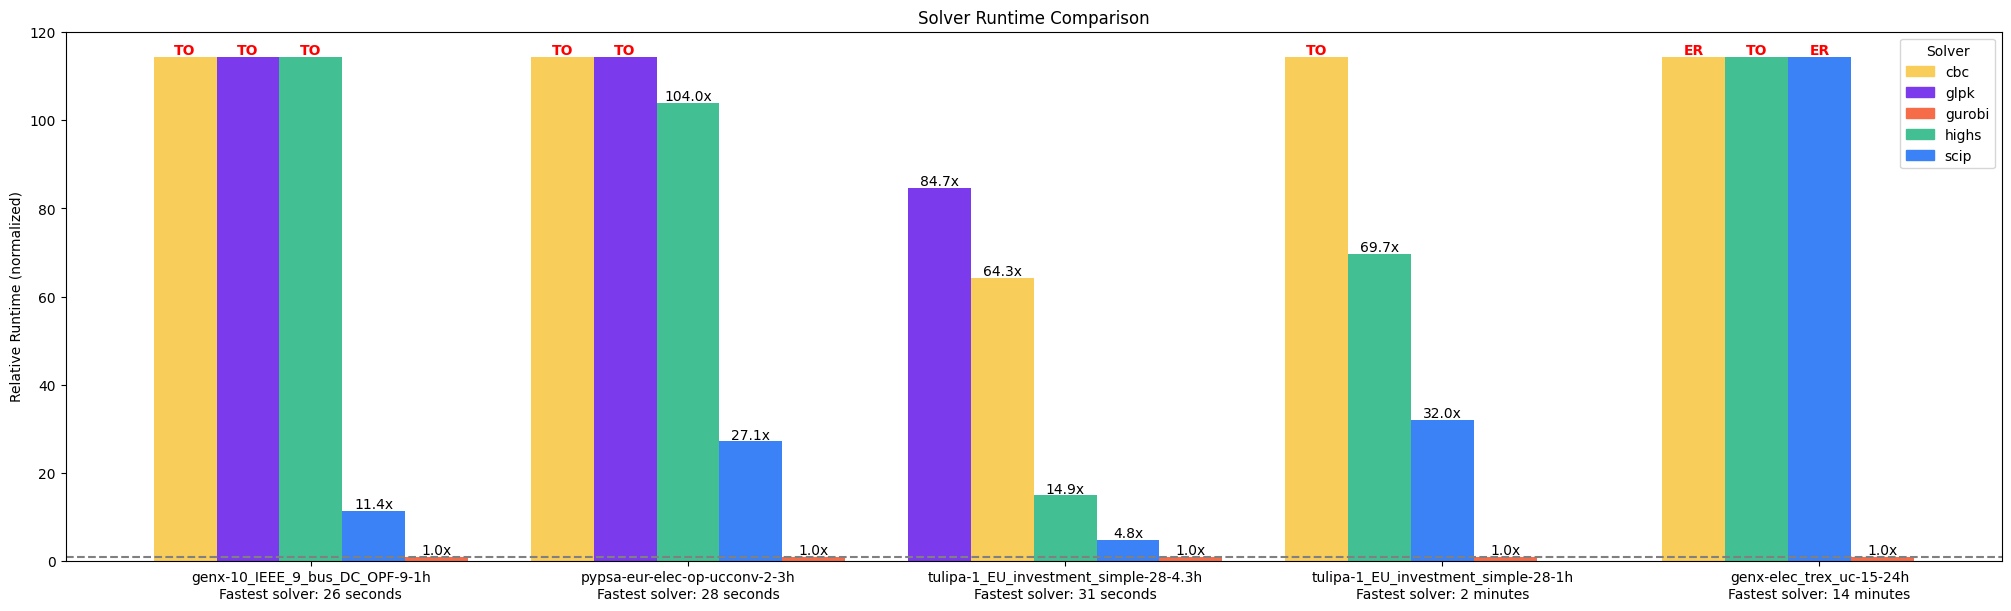

In [61]:
plot_runtime_slowdowns_of(results, set(largest_milp_results["bench-size"]))

In [93]:
# The largest LP problems available, solveable by open solvers, and solvable by Gurobi for each model framework

# Largest LPs solveable by open solvers
largest_lp_per_model = (
    os_feasible_results.query('`Problem Class` == "LP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")
)
# Add to this table the largest LP problems solveable by Gurobi
largest_lp_per_model = largest_lp_per_model.join(
    gurobi_results.query('`Problem Class` == "LP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")["Num. Variables"],
    rsuffix=" - Gurobi",
)
# Add to this table the largest LP problems available
largest_lp_per_model = largest_lp_per_model.join(
    results_n_meta.query('`Problem Class` == "LP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")["Num. Variables"],
    rsuffix=" - Available",
)
largest_lp_per_model = largest_lp_per_model.sort_values(
    "Num. Variables", ascending=False
)
largest_lp_per_model[
    [c for c in cols_of_interest if c != "Runtime - Gurobi"]
    + ["Num. Variables - Gurobi", "Num. Variables - Available"]
]

,Benchmark,Size,Num. Variables,Num. Constraints,Spatial Resolution,Temporal Resolution,Solver,Solver Version,Runtime,Num. Variables - Gurobi,Num. Variables - Available
Modelling Framework,,,,,,,,,,,
TEMOA,temoa-US_9R_TS_NZ,9-12,1801794,1594085,9 nodes,"12 time slices (4 seasons, 3 times of day)",highs,1.10.0,7 hours,1801794,1801794
TIMES,times-ireland-noco2-counties,26-1h,1235884,873805,26 (Transport) / 1 (all other sectors),1,highs,1.10.0,an hour,6449851,6449851
PyPSA,pypsa-eur-elec-op,2-1h,455458,928600,2,1,cbc,2.10.11,2 minutes,750434,750434
GenX,genx-8_three_zones_w_colocated_VRE_storage_ele...,3-1h,257129,302449,3,168,cbc,2.10.12,47 minutes,13777227,13777227
DCOPF,DCOPF-Carolinas_2M,1-997,122017,199255,997 nodes,1,highs,1.9.0,9 seconds,122017,122017


In [94]:
# The largest MILP problems available, solveable by open solvers, and solvable by Gurobi for each model framework

# Largest MILPs solveable by open solvers
largest_milp_per_model = (
    os_feasible_results.query('`Problem Class` == "MILP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")
)
# Add to this table the largest MILP problems solveable by Gurobi
largest_milp_per_model = largest_milp_per_model.join(
    gurobi_results.query('`Problem Class` == "MILP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")["Num. Variables"],
    rsuffix=" - Gurobi",
)
# Add to this table the largest MILP problems available
largest_milp_per_model = largest_milp_per_model.join(
    results_n_meta.query('`Problem Class` == "MILP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
    .set_index("Modelling Framework")["Num. Variables"],
    rsuffix=" - Available",
)
largest_milp_per_model = largest_milp_per_model.sort_values(
    "Num. Variables", ascending=False
)
largest_milp_per_model[
    [c for c in cols_of_interest if c != "Runtime - Gurobi"]
    + ["Num. Variables - Gurobi", "Num. Variables - Available"]
]

,Benchmark,Size,Num. Variables,Num. Constraints,Spatial Resolution,Temporal Resolution,Solver,Solver Version,Runtime,Num. Variables - Gurobi,Num. Variables - Available
Modelling Framework,,,,,,,,,,,
Tulipa,tulipa-1_EU_investment_simple,28-1h,1619451,2429440,28,1,scip,9.2.2,an hour,1619451,1619451
GenX,genx-10_IEEE_9_bus_DC_OPF,9-1h,639483,1235166,9,1,scip,9.2.2,5 minutes,2551346,2551346
PyPSA,pypsa-eur-elec-op-ucconv,2-3h,186880,385478,2,3,scip,9.2.2,12 minutes,186880,186880
DCOPF,DCOPF-Carolinas_uc_1W,1-997,131278,220143,997 nodes,1,scip,9.2.2,39 minutes,131278,131278
Sienna,Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon2...,1-1h,19392,25080,73,24,scip,8.0.3,16 minutes,38784,38784
PowerModels,pglib_opf_case2868,2868-NA,11045,25717,2868,NA,cbc,2.10.12,4 minutes,11045,11045


In [98]:
def plot_largest_probs(largest_per_model, lp_or_milp, figsize=(12, 6)):
    fig, ax = plt.subplots(figsize=figsize, layout="constrained")
    width = 0.25

    # Plot the OS results
    xs = np.arange(len(largest_per_model)) + width
    colors = [color_map[s] for s in largest_per_model["Solver"]]
    ax.bar(xs, largest_per_model["Num. Variables"], width, color=colors)

    # Add text labels of slowdowns on top of bars
    for i, x in enumerate(xs):
        slowdown = (
            largest_per_model.iloc[i]["Runtime (s)"]
            / largest_per_model.iloc[i]["Runtime (s) - Gurobi"]
        )
        label = f"{slowdown:.1f}x"
        ax.text(
            x, largest_per_model.iloc[i]["Num. Variables"] * 1.01, label, ha="center"
        )

    # Plot Gurobi results
    xs = np.arange(len(largest_per_model))
    colors = [color_map["gurobi"] for s in largest_per_model["Solver"]]
    ax.bar(xs, largest_per_model["Num. Variables - Gurobi"], width, color=colors)

    # Plot the largest available problem per model
    xs = np.arange(len(largest_per_model)) - width
    colors = ["#DDD" for _ in largest_per_model["Solver"]]
    ax.bar(xs, largest_per_model["Num. Variables - Available"], width, color=colors)

    # Set x-ticks and labels
    xlabels = [f"{i}" for i, r in largest_per_model.iterrows()]
    ax.set_xticks(np.arange(len(largest_per_model)), xlabels)

    # Add labels and title
    ax.set_xlabel("Modelling Framework")
    ax.set_ylabel("Number of Variables")
    ax.set_title(
        f"Largest {lp_or_milp} problems available, solvable by Gurobi, and solvable by open solvers"
    )
    legend = {"available in set": "#DDD", **color_map}
    ax.legend(
        handles=[Patch(color=c, label=s) for s, c in legend.items()],
        loc="upper right",
    )

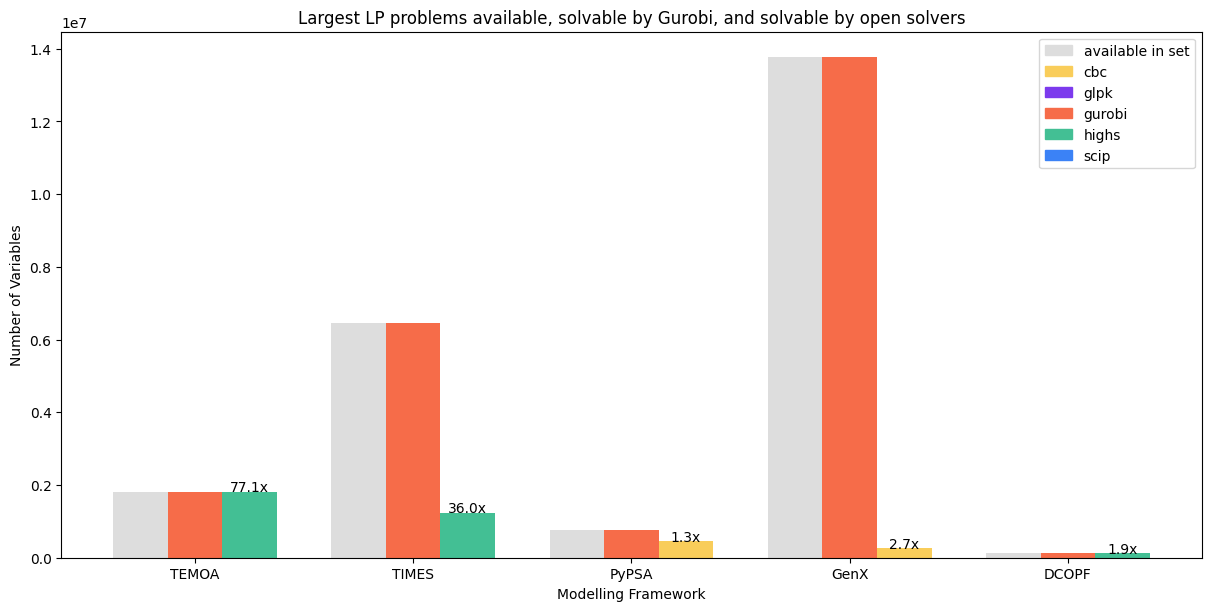

In [99]:
plot_largest_probs(largest_lp_per_model, "LP")

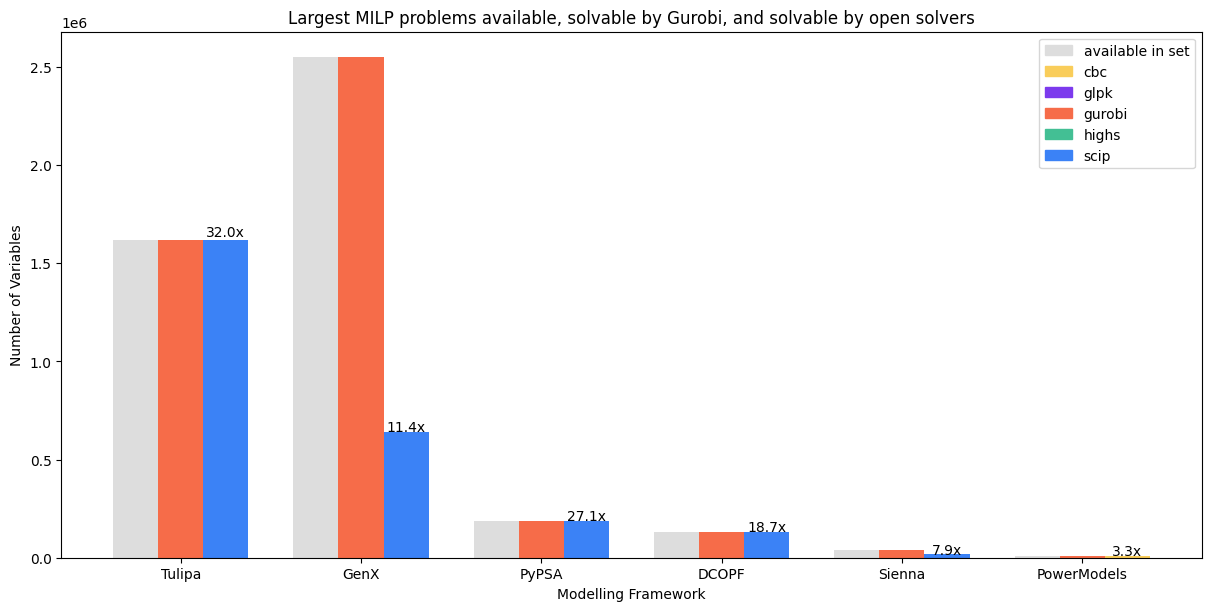

In [100]:
plot_largest_probs(largest_milp_per_model, "MILP")

## What factors affect solver performance?

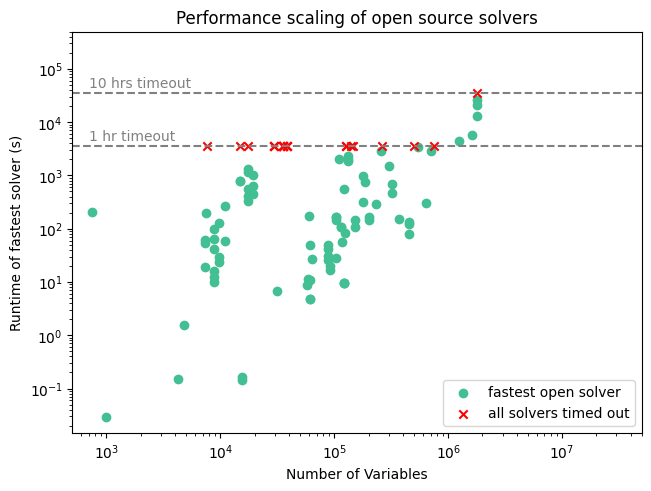

In [248]:
# Runtime vs number of variables for OS solvers and Gurobi
def plot_runtime_vs_num_vars(results, TO_results, title, color, label):
    fig, ax = plt.subplots(layout="constrained")
    # Add a dotted line at timeouts
    ax.axhline(60 * 60, color="grey", linestyle="--")
    ax.text(7e2, 60 * 60 + 1000, "1 hr timeout", color="grey")
    ax.axhline(10 * 60 * 60, color="grey", linestyle="--")
    ax.text(7e2, 10 * 60 * 60 + 10000, "10 hrs timeout", color="grey")
    ax.scatter(
        results["Num. Variables"],
        results["Runtime (s)"],
        c=color,
        label=label,
    )
    ax.scatter(
        TO_results["Num. Variables"],
        TO_results["Timeout"],
        c="red",
        marker="x",
        label="all solvers timed out",
    )
    ax.set_yscale("log")
    ax.set_ylim(None, 5e5)
    ax.set_xscale("log")
    ax.set_xlim(None, 5e7)
    ax.set_xlabel("Number of Variables")
    ax.set_ylabel("Runtime of fastest solver (s)")
    ax.set_title(title)
    ax.legend(loc="lower right")


os_statuses = (
    results_n_meta.query("Solver != 'gurobi'").groupby("bench-size")["Status"].unique()
)
os_TO_results = (
    results_n_meta.set_index("bench-size")
    .loc[os_statuses.astype(str) == "['TO']"]
    .reset_index()
    .drop_duplicates(["bench-size"])
)
plot_runtime_vs_num_vars(
    os_feasible_results,
    os_TO_results,
    "Performance scaling of open source solvers",
    color_map["highs"],
    "fastest open solver",
)

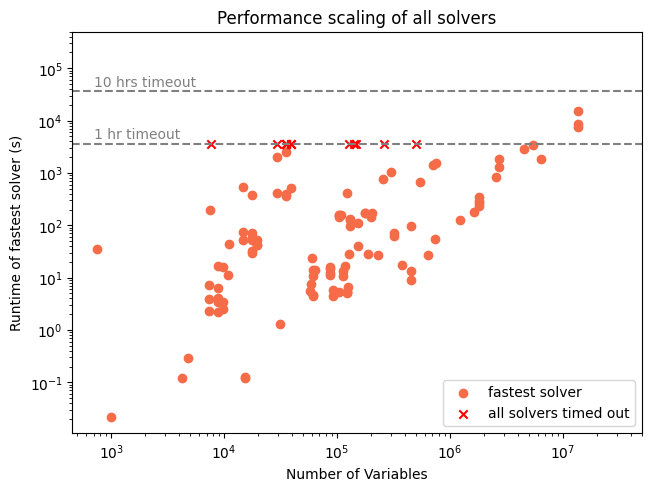

In [249]:
all_solver_results = (
    results_n_meta.query("Status == 'ok'")
    .sort_values("Runtime (s)")
    .drop_duplicates(["bench-size"])
)
all_statuses = results_n_meta.groupby("bench-size")["Status"].unique()
all_TO_results = (
    results_n_meta.set_index("bench-size")
    .loc[all_statuses.astype(str) == "['TO']"]
    .reset_index()
    .drop_duplicates(["bench-size"])
)
plot_runtime_vs_num_vars(
    all_solver_results,
    all_TO_results,
    "Performance scaling of all solvers",
    color_map["gurobi"],
    "fastest solver",
)

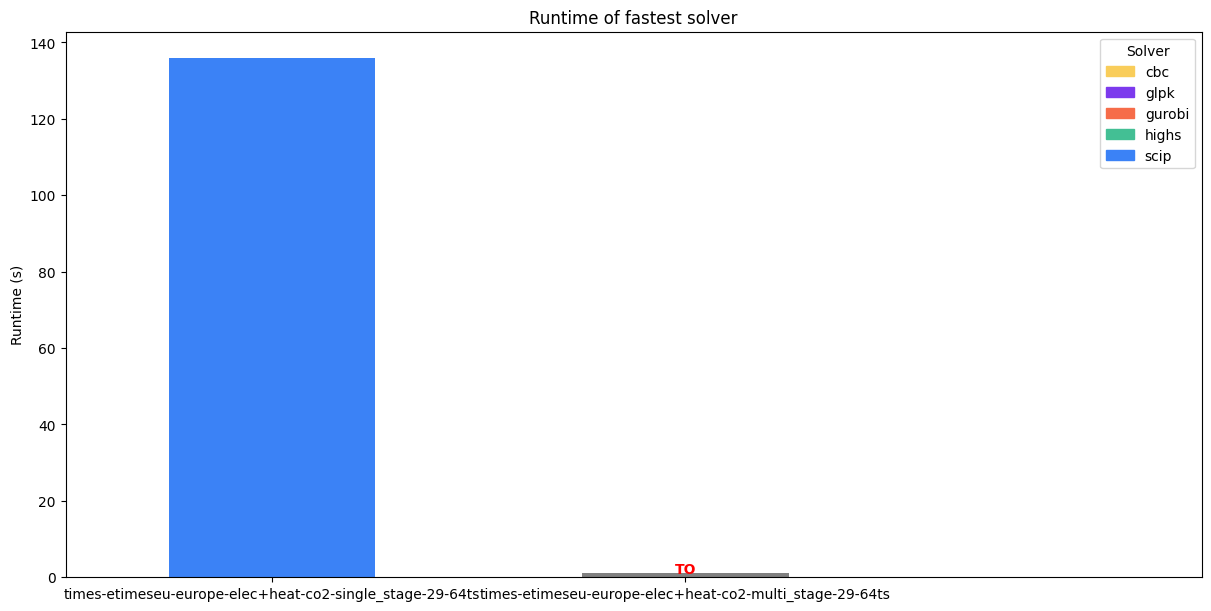

In [272]:
# Un-normalized runtime bar charts of the fastest (open) solver for a set of problems
def plot_fastest_runtime_of(to_plot, figsize=(8, 6), os_only=True):
    df = results[results["bench-size"].isin(set(to_plot))]

    # Fill NaN runtimes and non-ok statuses with TO value
    df.loc[df["Runtime (s)"].isna(), "Runtime (s)"] = df["Timeout"]
    df.loc[df.query('Status != "ok"').index, "Runtime (s)"] = df["Timeout"]

    # Find the fastest solver for each benchmark
    if os_only:
        df_ok = df.query('Status == "ok" and Solver != "gurobi"')
    else:
        df_ok = df.query('Status == "ok"')
    fastest_runtimes = df_ok.loc[
        df_ok.groupby("bench-size")["Runtime (s)"].idxmin()
    ].set_index("bench-size")

    width = 0.5

    fig, ax = plt.subplots(figsize=figsize, layout="constrained")
    # Plot each benchmark
    for i, benchmark in enumerate(to_plot):
        if benchmark in fastest_runtimes.index:
            this_data = fastest_runtimes.loc[benchmark]
            colors = [color_map[this_data["Solver"]]]
            ax.bar([i], this_data["Runtime (s)"], width, color=colors)
        else:
            to_bar_height = 1
            ax.bar([i], to_bar_height, width, color=["grey"])
            ax.text(i, to_bar_height, "TO", ha="center", color="red", weight="bold")

    # Set x-ticks and labels
    xlabels = [f"{benchmark}" for benchmark in to_plot]
    ax.set_xticks(np.arange(len(to_plot)), xlabels)

    # Add labels and title
    ax.set_ylabel("Runtime (s)")
    ax.set_xlim(-0.5, len(to_plot) + 0.25)
    ax.set_title("Runtime of fastest solver")
    ax.legend(
        handles=[Patch(color=c, label=s) for s, c in color_map.items()],
        title="Solver",
        loc="upper right",
    )


plot_fastest_runtime_of(
    # ["temoa-US_9R_TS-9-12", "temoa-US_9R_TS_NDC-9-12", "temoa-US_9R_TS_NZ-9-12"],
    # [
    #     "genx-elec_trex-15-168h",
    #     "genx-elec_trex_co2-15-168h",
    #     "genx-elec_trex_uc-15-24h",
    #     "genx-elec_co2-15-168h",
    # ],
    [
        "times-etimeseu-europe-elec+heat-co2-single_stage-29-64ts",
        "times-etimeseu-europe-elec+heat-co2-multi_stage-29-64ts",
    ],
    figsize=(12, 6),
)

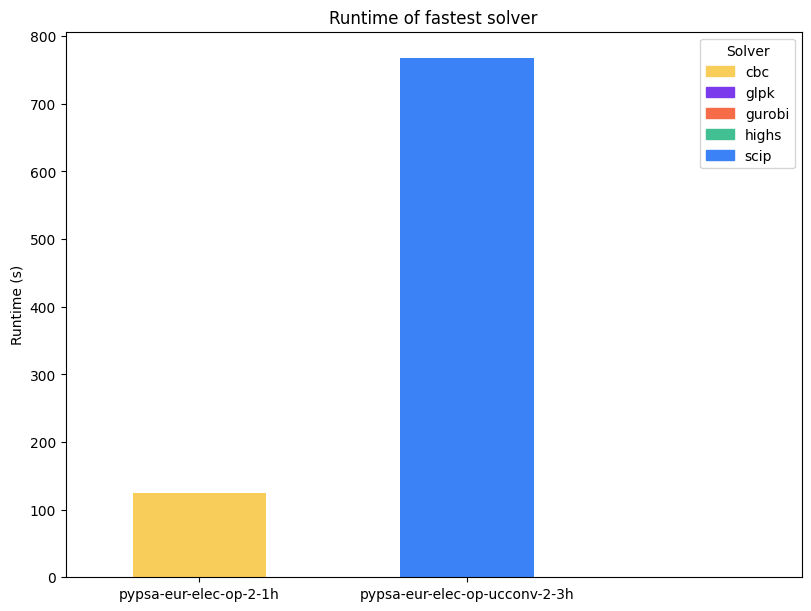

In [ ]:
# The effect of unit commitment (MILP feature) on PyPSA
plot_fastest_runtime_of(
    ["pypsa-eur-elec-op-2-1h", "pypsa-eur-elec-op-ucconv-2-3h"],
    figsize=(8, 6),
    os_only=False,
)

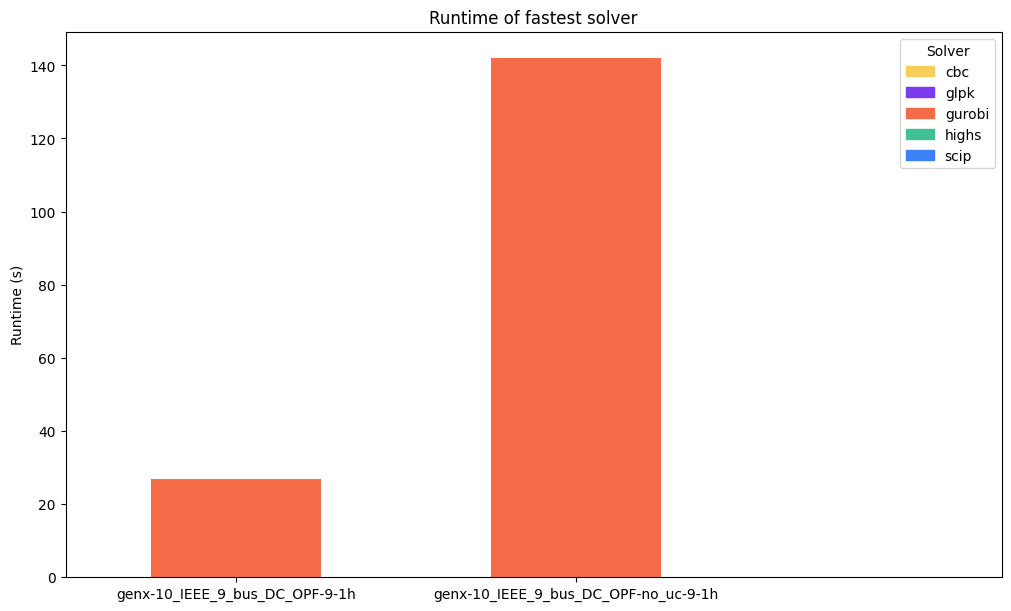

In [285]:
# The effect of unit commitment (MILP feature) on GenX
plot_fastest_runtime_of(
    ["genx-10_IEEE_9_bus_DC_OPF-9-1h", "genx-10_IEEE_9_bus_DC_OPF-no_uc-9-1h"],
    figsize=(10, 6),
    os_only=False,
)

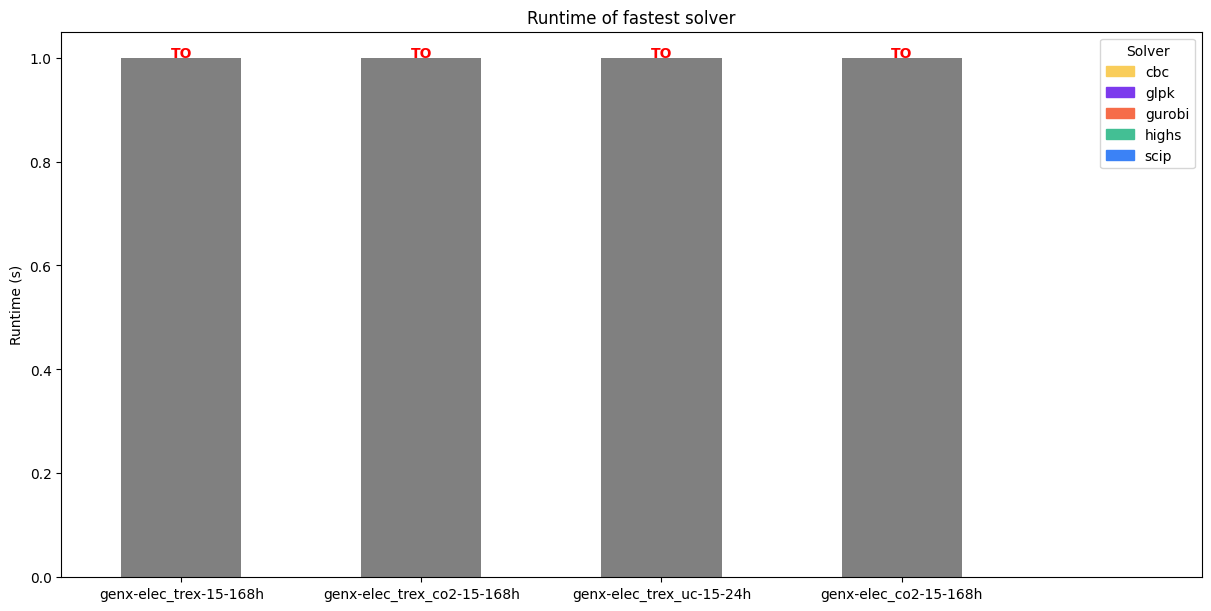

In [286]:
# The effect of UC, transmission expansion, and CO2 constraints in GenX
plot_fastest_runtime_of(
    [
        "genx-elec_trex-15-168h",
        "genx-elec_trex_co2-15-168h",
        "genx-elec_trex_uc-15-24h",
        "genx-elec_co2-15-168h",
    ],
    figsize=(12, 6),
    # os_only=False,
)

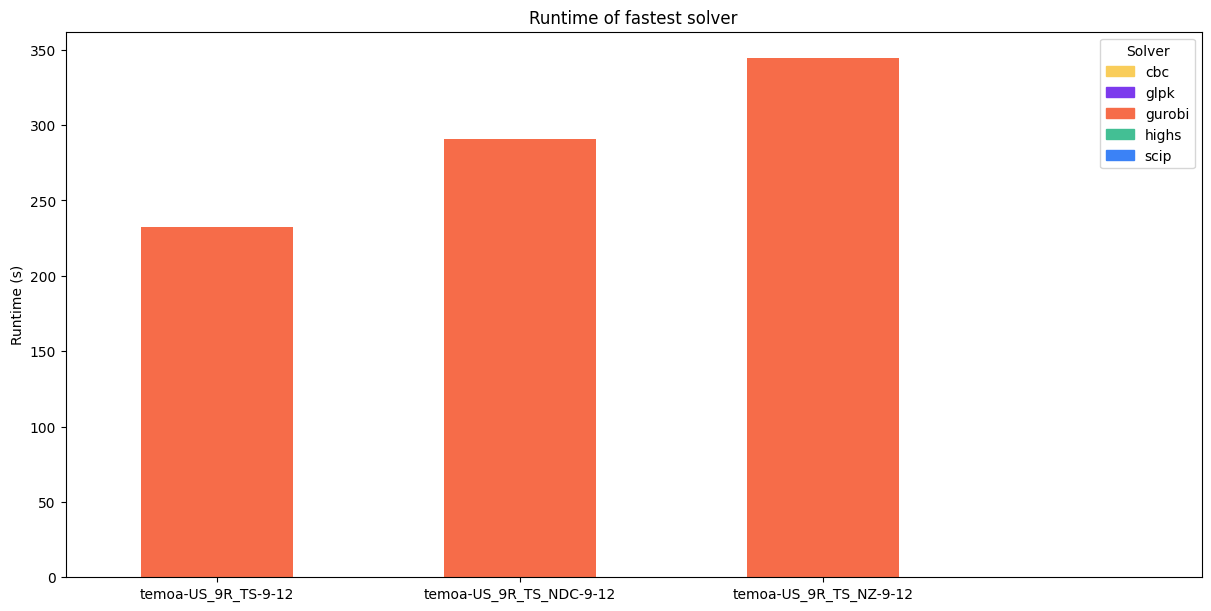

In [278]:
# The effect of CO2 constraints in TEMOA
plot_fastest_runtime_of(
    ["temoa-US_9R_TS-9-12", "temoa-US_9R_TS_NDC-9-12", "temoa-US_9R_TS_NZ-9-12"],
    figsize=(12, 6),
    os_only=False,
)

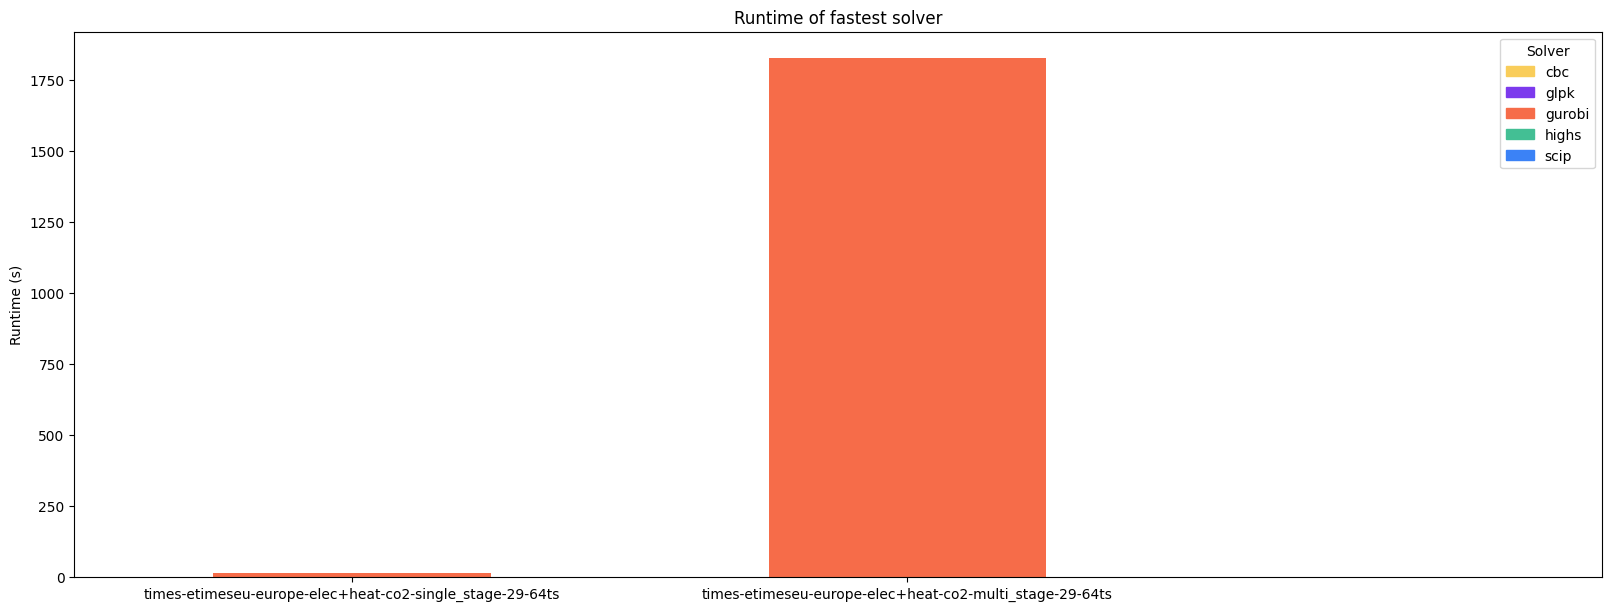

In [280]:
# The effect of time horizons in TIMES
plot_fastest_runtime_of(
    [
        "times-etimeseu-europe-elec+heat-co2-single_stage-29-64ts",
        "times-etimeseu-europe-elec+heat-co2-multi_stage-29-64ts",
    ],
    figsize=(16, 6),
    os_only=False,
)

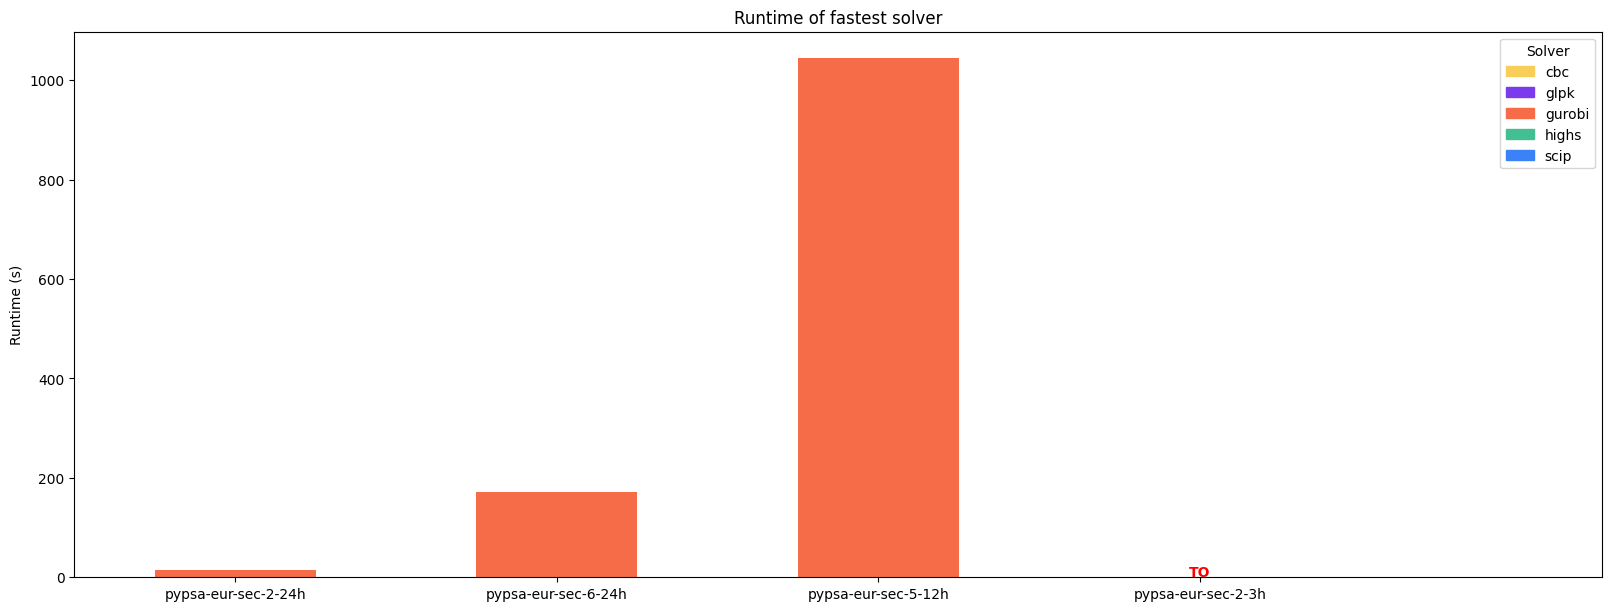

In [283]:
# Different size instances of pypsa models
plot_fastest_runtime_of(
    [
        "pypsa-eur-sec-2-24h",
        "pypsa-eur-sec-6-24h",
        "pypsa-eur-sec-5-12h",
        "pypsa-eur-sec-2-3h",
    ],
    figsize=(16, 6),
    os_only=False,
)